In [1]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
import pandas as pd
# The data was produced from the Iowa Alcohol Dataset 2019 year data.  The total data set size has over 17 million rows.  We took
# a subet of that data, 400,000 rows

# The 400k rows were cleansed and transformed lab1 and exported as a csv to github for use here.
# source python notebook: https://github.com/jjschueder/7331DataMiningNotebooks/blob/master/lab1/msds7331_clark_schueder_vela_washburn.ipynb

# Further cleansing was done to 1 hot encode some of the categorical features, which is what we are reading in here.  Still using 400k rows of data
data = pd.read_csv(r'C:/Users/jjsch/Documents/GitHub/7331lab1/7331DataMiningNotebooks/Live Assignments/df1hotmerge2.csv')
# read csv from github directly
#url_dataset = 'https://raw.githubusercontent.com/jjschueder/7331DataMiningNotebooks/master/Live%20Assignments/df1hotmerge2.csv'
#data = pd.read_csv(url_dataset) #full dataset of 400k rows
#data = pd.read_csv(url_dataset, nrows=100000) #smaller subset of data of nrows

In [3]:
data['liquor_category'].unique()

array(['Other', 'GIN', 'WHISKY', 'TEQUILA', 'LIQUEUR', 'VODKA', 'RUM',
       'SCHNAPPS', 'AMARETTO', 'BRANDY'], dtype=object)

In [4]:
df = pd.DataFrame({'col_1':[133,255,36,477,55,63]})
d = {'1':'M', '2': 'C', '3':'a', '4':'f', '5':'r', '6':'s'}
def ifef(col):
    col = str(col)
    return d[col[0]]

df['id_label'] = df['col_1'].apply(ifef)
print(df)

   col_1 id_label
0    133        M
1    255        C
2     36        a
3    477        f
4     55        r
5     63        s


In [5]:
d = {'O':'1', 'G': '2', 'W':'3', 'T':'4', 'L':'5', 'V':'6', 'R':'7', 'S': '8', 'A':'9', 'B':'10'}

#data['id_label'] = data['liquor_category'].apply(ifef)

data['id_label'] = data['liquor_category'].astype(str).str[0].map(d)


In [6]:
data.head()

,Unnamed: 0,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,counter,...,monthyear_Oct-2019,monthyear_Sep-2019,sale_dollars_trans,cost_per_liter,cost_per_liter_trans,state_bottle_cost_trans,bottles_sold_trans,volume_sold_liters_trans,grossmargin,id_label
0,0,20,375,3.85,5.78,20,115.60,7.50,1.98,1,...,0,0,4.750136,15.413333,2.735233,1.348073,2.995732,2.014903,0.333910,1
1,1,8,50,8.75,13.13,1,13.13,0.05,0.01,1,...,0,0,2.574900,262.600000,5.570632,2.169054,0.000000,-2.995732,0.333587,1
2,2,12,1000,16.50,24.75,6,148.50,6.00,1.58,1,...,0,0,5.000585,24.750000,3.208825,2.803360,1.791759,1.791759,0.333333,2
3,3,6,750,21.17,31.76,24,762.24,18.00,4.75,1,...,0,0,6.636261,42.346667,3.745890,3.052585,3.178054,2.890372,0.333438,3
4,4,6,1750,9.31,13.97,12,167.64,21.00,5.54,1,...,0,0,5.121819,7.982857,2.077296,2.231089,2.484907,3.044522,0.333572,1


In [7]:
# Remove unwanted columns, which include all the specific liquor categories, 
# except for liquor_category_WHISKY since that is what we want to classify on, along
# with all the store_ attributes
"""
cat_vars=['counter', 'liquor_category', 'store_parent',
 'month', 'year', 'monthyear', 'liquor_category_AMARETTO', 'liquor_category_BRANDY', 'liquor_category_GIN', 
 'liquor_category_LIQUEUR', 'liquor_category_Other', 'liquor_category_RUM', 'liquor_category_SCHNAPPS', 
 'liquor_category_TEQUILA', 'liquor_category_VODKA', 'month_Apr', 'month_Aug', 'month_Dec', 'month_Feb',
 'month_Jan', 'month_Jul', 'month_Jun', 'month_Mar', 'month_May', 'month_Nov', 'month_Oct', 'month_Sep', 
 'store_parent_CVS', 'store_parent_Caseys', 'store_parent_Hy-Vee', 'store_parent_Kum&Go', 
 'store_parent_Other', 'store_parent_QuikTrip', 'store_parent_SamsClub', 'store_parent_SmokingJoes', 
 'store_parent_Target', 'store_parent_Wal-Mart', 'store_parent_Walgreens']
data_vars=data.columns.values.tolist()
to_keep=[i for i in data_vars if i not in cat_vars]
"""
to_keep=['sale_dollars_trans', 'cost_per_liter_trans',
      'state_bottle_cost_trans', 'bottles_sold_trans',
       'volume_sold_liters_trans','pack', 'bottle_volume_ml',
       'id_label']
data_final=data[to_keep]
data_final.columns.values

array(['sale_dollars_trans', 'cost_per_liter_trans',
       'state_bottle_cost_trans', 'bottles_sold_trans',
       'volume_sold_liters_trans', 'pack', 'bottle_volume_ml', 'id_label'],
      dtype=object)

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# source of code: https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [9]:
%%time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn import metrics as mt


# create variables we are more familiar with
# X will be our features
X = data_final.loc[:, data_final.columns != 'id_label']
# y will be our label, what we are trying to classify
y = data_final.loc[:, data_final.columns == 'id_label']
yhat = np.zeros(y.shape) # we will fill this with predictions

# Import train_test_split function
from sklearn.model_selection import train_test_split

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3) # 70% training and 30% test

Wall time: 1.05 s


In [10]:
# scale attributes by the training set
scl_obj = StandardScaler()
scl_obj.fit(X_train) 

# apply to training on full dataset
X_train_scaled = scl_obj.transform(X_train) 
X_test_scaled = scl_obj.transform(X_test)


In [11]:
%%time
#Import knearest neighbors Classifier model
from sklearn.neighbors import KNeighborsClassifier

#Create KNN Classifier
knn = KNeighborsClassifier(n_neighbors=10, n_jobs =-1)

#Train the model using the training sets
knn.fit(X_train_scaled, y_train.values.ravel())

#Predict the response for test dataset
y_pred = knn.predict(X_test_scaled)

Wall time: 3min 23s


Accuracy: 0.9084666666666666


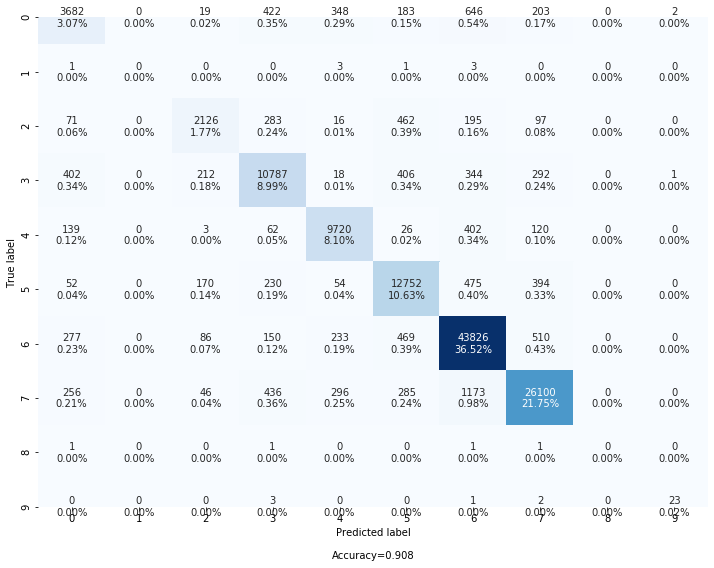

In [12]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
knn_matrix = confusion_matrix(y_test, y_pred)
make_confusion_matrix(knn_matrix, figsize=(12,9), cbar=False)

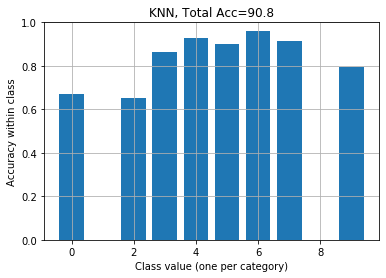

In [13]:
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

def per_class_accuracy(ytrue,yhat):
    conf = mt.confusion_matrix(ytrue,yhat)
    norm_conf = conf.astype('float') / conf.sum(axis=1)[:, np.newaxis]
    return np.diag(norm_conf)

def plot_class_acc(ytrue,yhat, title=''):
    acc_list = per_class_accuracy(ytrue,yhat)
    plt.bar(range(len(acc_list)), acc_list)
    plt.xlabel('Class value (one per category)')
    plt.ylabel('Accuracy within class')
    plt.title(title+", Total Acc=%.1f"%(100*mt.accuracy_score(ytrue,yhat)))
    plt.grid()
    plt.ylim([0,1])
    plt.show()
    
plot_class_acc(y_test,y_pred,title="KNN")

In [14]:
%%time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn import metrics as mt
scl = StandardScaler()

Wall time: 0 ns


In [12]:
# create cross validation iterator
cv = StratifiedKFold(n_splits=10)

# get a handle to the classifier object, which defines the type
clf = KNeighborsClassifier(n_neighbors=10, n_jobs = -1)

In [20]:
%%time
# now iterate through and get predictions, saved to the correct row in yhat
# NOTE: you can parallelize this using the cross_val_predict method
for train_idx, test_idx in cv.split(X,y):
     clf.fit(scl.fit_transform(X.iloc[train_idx]),y.iloc[train_idx].values.ravel())
#     yhat[test_idx ] = clf.predict(X.iloc[test_idx ])
     yhat2 = clf.predict(scl.transform(X.iloc[test_idx]))
#    X[train], y[train]
     total_accuracy = mt.accuracy_score(y.iloc[test_idx], yhat2)
     print ('KNN accuracy', total_accuracy)
#     clf_class_report = classification_report(y.iloc[test_idx], yhat2)
clf_matrix = confusion_matrix(y.iloc[test_idx], yhat2)

KNN accuracy 0.896125
KNN accuracy 0.889875
KNN accuracy 0.804425
KNN accuracy 0.493525
KNN accuracy 0.427575
KNN accuracy 0.4657
KNN accuracy 0.47015
KNN accuracy 0.835825
KNN accuracy 0.64415
KNN accuracy 0.434625
Wall time: 6min 5s


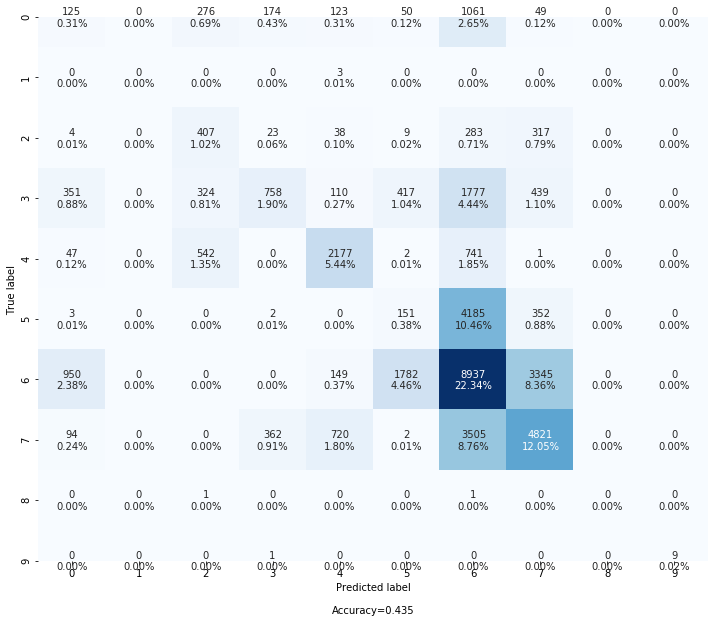

In [21]:
make_confusion_matrix(clf_matrix, figsize=(12,10), cbar=False)

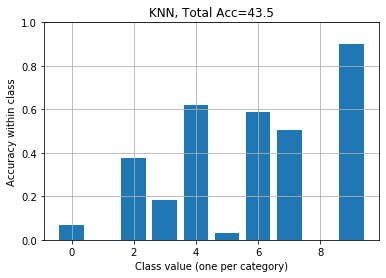

In [22]:
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

def per_class_accuracy(ytrue,yhat):
    conf = mt.confusion_matrix(ytrue,yhat)
    norm_conf = conf.astype('float') / conf.sum(axis=1)[:, np.newaxis]
    return np.diag(norm_conf)

def plot_class_acc(ytrue,yhat, title=''):
    acc_list = per_class_accuracy(ytrue,yhat)
    plt.bar(range(len(acc_list)), acc_list)
    plt.xlabel('Class value (one per category)')
    plt.ylabel('Accuracy within class')
    plt.title(title+", Total Acc=%.1f"%(100*mt.accuracy_score(ytrue,yhat)))
    plt.grid()
    plt.ylim([0,1])
    plt.show()
    
plot_class_acc(y.iloc[test_idx], yhat2,title="KNN")

In [16]:
%%time
from sklearn.model_selection import GridSearchCV
#create new a knn model
knn2 = KNeighborsClassifier()
#create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_neighbors': [5, 10, 15, 20]}
#    'weights' : ['uniform', 'distance'],
#    'metric' : ['euclidean', 'manhatten'],
#    'algorithm' : ['ball_tree', 'kd_tree', 'brute']}
#use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn2, param_grid, n_jobs = -1, cv=2, verbose = 1)
#fit model to data
knn_gscv.fit(X_train_scaled, y_train.values.ravel())

Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:  2.0min remaining:  6.1min
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  2.1min finished


Wall time: 2min 50s


GridSearchCV(cv=2, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=-1,
             param_grid={'n_neighbors': [5, 10, 15, 20]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=1)